In [1]:
import sys
import tqdm
import pandas as pd
import numpy as np

sys.path.append("..")
from util import load_base_data

import neurokit2 as nk

SAMPLING_RATE = 300

In [2]:
X_train, y_train, X_test = load_base_data()

In [3]:
def make_signals(ecg):
    signals, info = nk.ecg_process(ecg_signal=ecg, sampling_rate=SAMPLING_RATE)
    nk.ecg_plot(signals, info)
    return signals, info

In [4]:
def make_features(ecg):
    signals, info = make_signals(ecg)
    features = nk.ecg_intervalrelated(signals, sampling_rate=SAMPLING_RATE)
    return features

/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:101: NeuroKitWarning: There are 1485 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:153: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

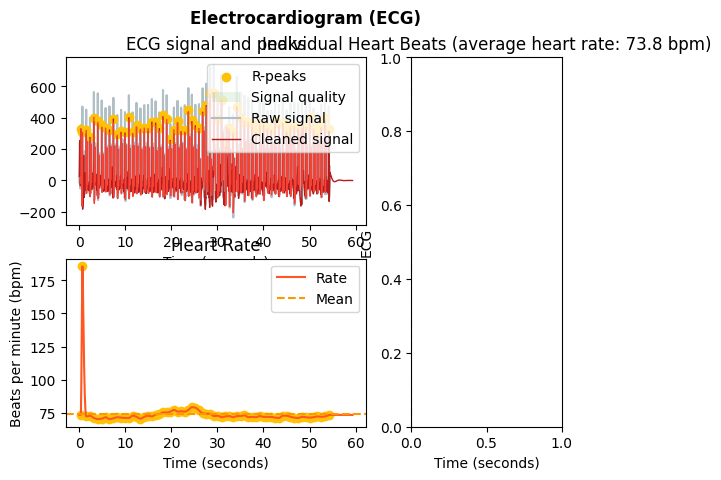

In [5]:
ecg_features = make_features(X_train.iloc[0])

# Bio Process

In [ ]:
preprocessed, info = nk.bio_process(ecg=X_train.iloc[0], sampling_rate=SAMPLING_RATE)
results = nk.bio_analyze(preprocessed, sampling_rate=SAMPLING_RATE)

/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:101: NeuroKitWarning: There are 1485 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:153: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


In [ ]:
results

ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN HRV_SDANN1  \
0     73.815985  [[815.8585858585858]]  [[65.38266218878302]]    [[nan]]   

  HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5  \
0    [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   

               HRV_RMSSD  ...              HRV_SampEn             HRV_ShanEn  \
0  [[63.71142204617081]]  ...  [[0.4525695772956377]]  [[4.141016711134489]]   

               HRV_FuzzyEn                 HRV_MSEn               HRV_CMSEn  \
0  [[0.38566264652850274]]  [[0.21603864749890622]]  [[0.3809198942913523]]   

                HRV_RCMSEn                  HRV_CD                 HRV_HFD  \
0  [[0.35528471260811445]]  [[0.7900848196990945]]  [[1.7042804985314337]]   

                  HRV_KFD                  HRV_LZC  
0  [[1.1947648984005386]]  [[0.45790864540594345]]  

[1 rows x 83 columns]

# HRV Indices
Already contained in the above analysis.

In [40]:
def make_hrv(ecg):
    peaks, info = nk.ecg_peaks(ecg, sampling_rate=SAMPLING_RATE)
    hrv_indices = nk.hrv(peaks, sampling_rate=SAMPLING_RATE, show=True)
    return hrv_indices

/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


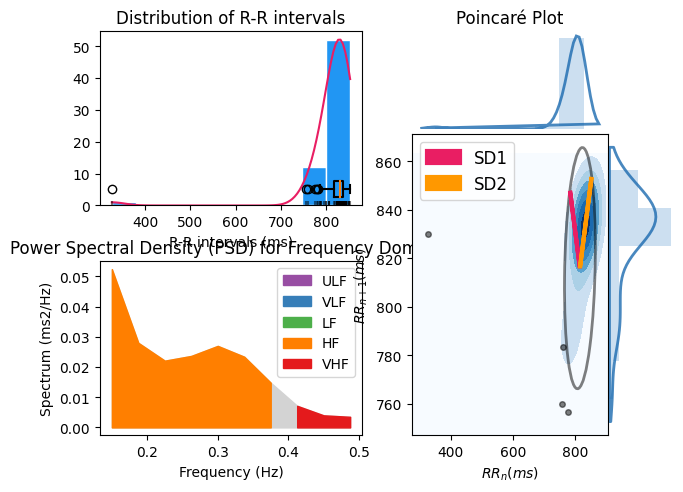

In [41]:
hrv_indices = make_hrv(X_train.iloc[0])

In [46]:
hrv_indices

HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  815.897436  65.446568         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_SampEn  HRV_ShanEn  \
0         NaN         NaN  63.654613  63.666257  ...    0.374693    4.099141   

   HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn   HRV_CD   HRV_HFD   HRV_KFD  \
0     0.364332  0.207445   0.375777    0.355069  0.77074  1.689945  1.176653   

    HRV_LZC  
0  0.463259  

[1 rows x 82 columns]

In [49]:
# check if all the colums of hrv_indeces are already contained in the results
for col in hrv_indices.columns:
    if col not in results.columns:
        print(col)

# Generate the features

In [10]:
def clean_input(ecg):
    #  filtered using a finite impulse response bandpass filter
    cleaned = nk.ecg_clean(ecg, sampling_rate=SAMPLING_RATE, method="biosppy")
    cleaned, was_inverted = nk.ecg_invert(cleaned, sampling_rate=300, show=False)
    # _, info = nk.ecg_peaks(ecg_cleaned=cleaned, sampling_rate=SAMPLING_RATE)
    # rpeaks = info["ECG_R_Peaks"]
    return cleaned

In [11]:
def make_features(ecg):
    cleaned = clean_input(ecg)
    preprocessed, info = nk.bio_process(ecg=cleaned, sampling_rate=SAMPLING_RATE)
    results = nk.bio_analyze(preprocessed, sampling_rate=SAMPLING_RATE)
    return results


def make_features_from_df(df):
    # features = df.apply(make_features, axis=0)
    feature_shape = make_features(df.iloc[0]).shape
    col_names = make_features(df.iloc[0]).columns
    print(f"Feature shape: {feature_shape}")
    not_features_row = 0
    for i in tqdm.tqdm(range(len(df))):
        try:
            features = make_features(df.iloc[i])
        except:
            features = pd.DataFrame(np.zeros(feature_shape), columns=col_names)
            not_features_row += 1

        if i == 0:
            features_df = features
        else:
            features_df = pd.concat([features_df, features], axis=0)

    features_df = features_df.reset_index(drop=True)
    features_df.index.name = "id"

    print("********** FINISHED ********** \n\n")
    print(f"Could not extract features from {not_features_row} rows")

    return features_df

In [12]:
features_X_train = make_features_from_df(X_train)

/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:101: NeuroKitWarning: There are 1485 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:153: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2

Feature shape: (1, 83)


  0%|          | 0/5117 [00:00<?, ?it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:101: NeuroKitWarning: There are 1485 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:153: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
  0%|          | 1/5117 [00:00<38:02,  2.24it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/

********** FINISHED ********** 


Could not extract features from 111 rows


In [13]:
features_X_train

ECG_Rate_Mean              HRV_MeanNN                HRV_SDNN HRV_SDANN1  \
id                                                                              
0        73.816026   [[815.8585858585858]]   [[65.39311918130252]]    [[nan]]   
1        72.456698   [[790.1904761904763]]   [[46.37826046634588]]    [[nan]]   
2        68.765001   [[900.6896551724137]]   [[35.91634140107747]]    [[nan]]   
3       128.924632  [[393.98148148148147]]   [[63.82350195533897]]    [[nan]]   
4         99.05752   [[612.1481481481482]]   [[51.09485907621193]]    [[nan]]   
...            ...                     ...                     ...        ...   
5112     73.701276   [[718.0952380952381]]    [[201.677882411454]]    [[nan]]   
5113     67.540406   [[864.7311827956988]]   [[17.14371050956712]]    [[nan]]   
5114     75.259152   [[790.7619047619047]]   [[94.52006639075925]]    [[nan]]   
5115     70.511976   [[848.3333333333334]]   [[28.46112861946813]]    [[nan]]   
5116    100.687792   [[591.2121212121212]]  [[36.338139992779446]]    [[nan]]   

     HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5  \
id                                                            
0       [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   
1       [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   
2       [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   
3       [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   
4       [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   
...         ...        ...        ...        ...        ...   
5112    [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   
5113    [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   
5114    [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   
5115    [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   
5116    [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   

                   HRV_RMSSD  ...                  HRV_LZC  \
id                            ...                            
0      [[63.73020054525532]]  ...  [[0.45790864540594345]]   
1     [[29.076190200941177]]  ...   [[0.8793056600477085]]   
2      [[26.53240007930406]]  ...   [[1.3401326883110543]]   
3      [[87.19144119602781]]  ...   [[1.0283208335737186]]   
4      [[17.33508149692555]]  ...  [[0.48816471967374886]]   
...                      ...  ...                      ...   
5112   [[211.7703158298317]]  ...   [[1.4641058075929203]]   
5113   [[17.29911151646981]]  ...    [[1.438315057854254]]   
5114  [[35.992010732957205]]  ...  [[0.43965283002385425]]   
5115  [[35.786102907278476]]  ...              [[1.09375]]   
5116   [[15.56016912019582]]  ...    [[0.868545939328661]]   

              HRV_DFA_alpha2  HRV_MFDFA_alpha2_Width   HRV_MFDFA_alpha2_Peak  \
id                                                                             
0                        NaN                     NaN                     NaN   
1                        NaN                     NaN                     NaN   
2                        NaN                     NaN                     NaN   
3                        NaN                     NaN                     NaN   
4                        NaN                     NaN                     NaN   
...                      ...                     ...                     ...   
5112  [[0.9698140531918784]]  [[1.1149787265374913]]  [[0.4805378751921223]]   
5113  [[0.9698140531918784]]  [[1.1149787265374913]]  [[0.4805378751921223]]   
5114  [[0.9698140531918784]]  [[1.1149787265374913]]  [[0.4805378751921223]]   
5115  [[0.9698140531918784]]  [[1.1149787265374913]]  [[0.4805378751921223]]   
5116  [[0.9698140531918784]]  [[1.1149787265374913]]  [[0.4805378751921223]]   

       HRV_MFDFA_alpha2_Mean HRV_MFDFA_alpha2_Max  HRV_MFDFA_alpha2_Delta  \
id                                                                          
0                        NaN                  NaN                     NaN   
1                        NaN                  NaN   

In [14]:
# # Drop the rows in y_train that were dropped in X_train
# y_train_len = len(y_train)
# y_train_dropped = y_train.drop(dropped_idx)
# y_train_dropped = y_train_dropped.reset_index(drop=True)
# y_train_dropped.index.name = "id"
# print(f"dropped {y_train_len - len(y_train_dropped)} rows")

# NO NEED FOR DROPPING. THE ROWS WILL BE 0

In [15]:
# How many infs
print(f"Number of infs: {np.sum(np.isinf(features_X_train), axis=0).sum()}")
# Which columns have infs
cols_with_infs = np.where(np.isinf(features_X_train))[1]
cols_with_infs_unique = np.unique(cols_with_infs)
print(f"Columns with infs: {len(cols_with_infs_unique)}")
# Numbers bigger than 1'000'000
print(
    f"Number of values bigger than 1'000'000: {np.sum((features_X_train > 1000000), axis=0).sum()}"
)
# Cap everything bigger than 1'000'000 to 1'000'000
features_X_train[features_X_train > 1000000] = 1000000
# Numbers smaller than -1000000
print(
    f"Number of values smaller than -1000000: {np.sum((features_X_train < -10000), axis=0).sum()}"
)
# Cap everything smaller than -1000000 to -1000000
features_X_train[features_X_train < -1000000] = -1000000
# Cap inf to 2'000'000
features_X_train[np.isinf(features_X_train)] = 2000000
# Cap -inf to -2000000
features_X_train[np.isneginf(features_X_train)] = -2000000

# How many nans
print(f"Number of nans: {np.sum(np.isnan(features_X_train), axis=0).sum()}")
# Which columns have nans
cols_with_nans = np.where(np.isnan(features_X_train))[1]
cols_with_nans_unique = np.unique(cols_with_nans)
print(f"Columns with nans: {len(cols_with_nans_unique)}")

TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
X_train_save_path = "/Users/ericschreiber/dev/ETH/AML/Project_1/aml-2023/task2/data/feature_extraction/neurokit2_X_train.csv"
features_X_train.to_csv(X_train_save_path, index=True)
y_train_save_path = "/Users/ericschreiber/dev/ETH/AML/Project_1/aml-2023/task2/data/feature_extraction/neurokit2_y_train.csv"
y_train.to_csv(y_train_save_path, index=True)
# dropped_cols_save_path = "/Users/ericschreiber/dev/ETH/AML/Project_1/aml-2023/task2/data/feature_extraction/neurokit2_dropped_cols_train.csv"
# dropped_cols = pd.DataFrame(dropped_idx)
# dropped_cols.to_csv(dropped_cols_save_path, index=False)

# Compute the test features

In [ ]:
features_X_test = make_features_from_df(X_test)
features_X_test_double = features_X_test

/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:69: NeuroKitWarning: There are 9658 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(


/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:486: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `windows` argument in `nk.fractal_dfa()` for more information.
  warn(
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/complexity/entropy_multiscale.py:202: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:69: NeuroKitWarning: There are 9658 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:486: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. 

Feature shape: (1, 78)


  0%|          | 0/3411 [00:00<?, ?it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/ecg/ecg_clean.py:69: NeuroKitWarning: There are 9658 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:486: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `windows` argument in `nk.fractal_dfa()` for more information.
  warn(
/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/complexity/entropy_multiscale.py:202: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)
  0%|          | 1/3411 [00:00<20:12,  2.81it/s]/Users/ericschreiber/miniconda3/envs/ml/lib/python3.10/site-packages/neurokit2/ecg/ec

********** FINISHED ********** 


Could not extract features from 46 rows
      ECG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  \
id                                                                     
0         70.144800   857.526882   58.638679         NaN         NaN   
1         56.689344  1049.259259  124.036446         NaN         NaN   
2         64.878185   879.333333  239.394831         NaN         NaN   
3         63.185302   963.928571   18.615750         NaN         NaN   
4         62.479972   988.765432   50.857167         NaN         NaN   
...             ...          ...         ...         ...         ...   
3406      88.318968   689.035088  137.554593         NaN         NaN   
3407      61.118641   905.111111  217.027521         NaN         NaN   
3408      79.023799   760.140845   56.966815         NaN         NaN   
3409      83.640213   729.298246    9.684448         NaN         NaN   
3410      83.759218   592.814815  126.528943         NaN      

In [ ]:
features_X_test = features_X_test_double

In [ ]:
# # Insert the dropped rows as NaNs
# features_X_test_np = features_X_test.to_numpy()
# for i in tqdm.tqdm(dropped_idx_test):
#     features_X_test_np = np.insert(features_X_test_np, i, np.nan, axis=0)

# features_X_test = pd.DataFrame(features_X_test_np, columns=features_X_test.columns)

# assert len(features_X_test) == len(X_test)
# features_X_test.reset_index(drop=True)
# features_X_test.index.name = "id"

# NO NEED FOR DROPPING. THE ROWS WILL BE 0

In [ ]:
# How many infs
print(f"Number of infs: {np.sum(np.isinf(features_X_test), axis=0).sum()}")
# Which columns have infs
cols_with_infs = np.where(np.isinf(features_X_test))[1]
cols_with_infs_unique = np.unique(cols_with_infs)
print(f"Columns with infs: {len(cols_with_infs_unique)}")
# Numbers bigger than 1'000'000
print(
    f"Number of values bigger than 1'000'000: {np.sum((features_X_test > 1000000), axis=0).sum()}"
)
# Cap everything bigger than 1'000'000 to 1'000'000
features_X_test[features_X_test > 1000000] = 1000000
# Numbers smaller than -1000000
print(
    f"Number of values smaller than -1000000: {np.sum((features_X_test < -10000), axis=0).sum()}"
)
# Cap everything smaller than -1000000 to -1000000
features_X_test[features_X_test < -1000000] = -1000000
# Cap inf to 2'000'000
features_X_test[np.isinf(features_X_test)] = 2000000
# Cap -inf to -2000000
features_X_test[np.isneginf(features_X_test)] = -2000000

# How many nans
print(f"Number of nans: {np.sum(np.isnan(features_X_test), axis=0).sum()}")
# Which columns have nans
cols_with_nans = np.where(np.isnan(features_X_test))[1]
cols_with_nans_unique = np.unique(cols_with_nans)
print(f"Columns with nans: {len(cols_with_nans_unique)}")

Number of infs: 644
Columns with infs: 1
Number of values bigger than 1'000'000: 624
Number of values smaller than -1000000: 52
Number of nans: 46009
Columns with nans: 19


In [ ]:
X_test_save_path = "/Users/ericschreiber/dev/ETH/AML/Project_1/aml-2023/task2/data/feature_extraction/neurokit2_X_test.csv"
features_X_test.to_csv(X_test_save_path, index=True)

In [ ]:
# Number of rows that only contain 0
rows_with_only_0 = 0
for i in range(len(features_X_test)):
    if features_X_test.iloc[i].sum() == 0:
        rows_with_only_0 += 1

print(f"Number of rows that only contain 0: {rows_with_only_0}")

Number of rows that only contain 0: 46
